In [ ]:
# INSTALL IF NEEDED:

!pip install spacy emoji optuna

In [2]:
# CONNECT TO COLAB IF NEEDED:

from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('./drive/MyDrive/data/tue_lai')

Mounted at /content/drive


## Load the data

In [3]:
import pandas as pd

data_path = 'political_leaning.csv'  # gender / birth_year
data = pd.read_csv(data_path)
data.head()

,auhtor_ID,post,political_leaning
0,t2_7ramzeng,"You can ""buy"" the show and stream it through t...",right
1,t2_7ramzeng,"me want to play Q*bert Holy shit, based Alex J...",right
2,t2_7ramzeng,Shouldn't rely on any external services or per...,right
3,t2_7ramzeng,PR to a specific person. Usually that just mea...,right
4,t2_7ramzeng,This article's intention is clear that they wa...,right


In [4]:
TARGET_COL = 'political_leaning'
CLASS_SIZE = 500
data_samples = []

for val in data[TARGET_COL].unique():
    data_samples.append(data[data[TARGET_COL] == val].sample(CLASS_SIZE))
data = pd.concat(data_samples)

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

INDEPENDENT_COL = 'post'


def label_encode(df, col_name):
    label_encoder = LabelEncoder()
    df[col_name] = label_encoder.fit_transform(df[col_name])
    return df, label_encoder


df, le = label_encode(data, TARGET_COL)
X_train, X_test, y_train, y_test = train_test_split(df[INDEPENDENT_COL], df[TARGET_COL])

## Data Pipelines

In [6]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin

import string
import emoji

import numpy as np

nltk.download("punkt")
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [7]:
def scale_array(array):
    scaler = MinMaxScaler()
    return scaler.fit_transform(np.array(array).reshape(-1,1))


class StylometryFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        stylometry_features = []
        for text in X:
            # Tokenize sentences and words
            sentences = [word_tokenize(sentence) for sentence in sent_tokenize(text)]
            words = [word for sentence in sentences for word in sentence]

            # Basic stylometry features
            features = {
                'sentence_count': len(sentences),
                'word_count': len(words),
                'avg_sentence_length': len(words) / len(sentences) if len(sentences) > 0 else 0,
                'avg_word_length': sum(len(word) for word in words) / len(words) if len(words) > 0 else 0,
                'num_punctuation': sum(1 for char in text if char in string.punctuation),
                'num_uppercase': sum(1 for char in text if char.isupper()),
                'num_digits': sum(1 for char in text if char.isdigit()),
                'num_emojis': len([char for char in text if char in emoji.EMOJI_DATA])
            }

            stylometry_features.append(features)

        return pd.DataFrame(stylometry_features)

In [8]:
import spacy

SPACY = spacy.load("en_core_web_sm")


class PosFeatures(BaseEstimator, TransformerMixin):
    """
    A class to extract POS features: for each post returns a list of corresponding POS tags
    """
    def __init__(self, include_tfidf=False, length_percentile=95):
        self.include_tfidf = include_tfidf
        self.length_percentile = length_percentile
        self._standartization_factor = 0

    def transform(self, X, *_):
        assert (self.sentence_size is not None), "Fitting required"

        # Create the output matrix
        result = np.zeros((len(X), self.sentence_size), dtype='uint8')

        for i, x in enumerate(SPACY.pipe(X, batch_size=50)):
            # Store the POS-tags
            tags = np.fromiter((token.pos for token in x), dtype='uint8', count=len(x))

            # Pad and truncate data, if necessary, and store them in result
            last_index = len(tags) if len(tags) < self.sentence_size else self.sentence_size
            result[i, :last_index] = tags[:last_index]

        # Generate the factor one time to ensure applying the same factor at the next transformations
        if self._standartization_factor == 0:
            self._standartization_factor = np.min(result[result != 0]) - 1

        # Standartize all valid elements to count from 1
        result[result != 0] -= self._standartization_factor
        return result

    def fit(self, X, *_):
        # Define an optimal sentence size covering a specific percent of all sample
        self.sentence_size = int(np.percentile([len(t.split()) for t in X], self.length_percentile))
        return self

    def fit_transform(self, X, *_):
        self.fit(X)
        return self.transform(X)

In [9]:
def get_single_pipeline_data(transformer):
    output = dict()
    X_processed = transformer.fit_transform(X_train)
    split = train_test_split(X_processed, y_train, test_size=0.25,random_state=42)
    output['X_train'], output['X_val'], output['y_train'], output['y_val'] = split
    output['X_test'] = transformer.transform(X_test)
    return output

def get_pipeline_data():
    result = dict()
    result['pos'] = get_single_pipeline_data(PosFeatures())
    result['style'] = get_single_pipeline_data(StylometryFeatureExtractor())
    transformer = FeatureUnion([
        ("style", StylometryFeatureExtractor()),
        ("tfidf", TfidfVectorizer(stop_words='english'))
    ])
    result['style_tfidf'] = get_single_pipeline_data(transformer)
    return result

In [10]:
pipelines_data = get_pipeline_data()

## Classifier Pipelines

In [11]:
import torch
from torch import nn
from torch import optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNNClassifier(nn.Module):
    def __init__(self, rnn_type, hidden_size, output_size, input_size, dropout, num_layers, bidirectional):
        super().__init__()
        assert (rnn_type in ['gru', 'lstm', 'simple']), "Invalid RNN type"

        rnn_params = {
            "hidden_size": hidden_size,
            "input_size": input_size,
            "dropout": dropout,
            "num_layers": num_layers,
            "bidirectional": bidirectional
        }

        if rnn_type == 'gru':
            self.rnn = nn.GRU(**rnn_params)
        elif rnn_type == 'lstm':
            self.rnn = nn.LSTM(**rnn_params)
        else:
            self.rnn = nn.RNN(**rnn_params)

        self.rnn_type = rnn_type
        self.fc = nn.Linear(
            (1 + bidirectional) * hidden_size,
            output_size
        )
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_seq):
        batch_size, seq_len, input_size = input_seq.shape

        if self.rnn_type == 'lstm':
            rnn_output, (last_hidden_state, last_cell_state) = self.rnn(input_seq)
        else:
            rnn_output, last_hidden_stwate = self.rnn(input_seq)

        last_output = rnn_output[:, -1, :]
        output = self.fc(last_output).view(batch_size, -1)
        output_probs = self.softmax(output)
        return output_probs


In [50]:
from torch.utils.data import DataLoader

class RnnSklearnWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self,
                 batch_size=32,
                 epochs=3,
                 dropout=0,
                 rnn_type='gru',
                 hidden_size=300,
                 num_layers=1,
                 bidirectional=False):

        self.batch_size = batch_size
        self.epochs = epochs
        self.dropout = dropout
        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self._model = None

    def fit(self, X, Y=None):
        assert (Y is not None), "Y is required"
        self.num_tags = np.max(X) + 1

        rnn_params = {
            "rnn_type": self.rnn_type,
            "input_size": self.num_tags,
            "output_size": np.max(Y) + 1,
            "hidden_size": self.hidden_size,
            "dropout": self.dropout,
            "num_layers": self.num_layers,
            "bidirectional": self.bidirectional
        }
        self.model = RNNClassifier(**rnn_params).to(DEVICE)
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()
        for epoch in range(self.epochs):
            running_loss = 0
            for X_batch, y_batch in DataLoader(list(zip(X, Y)), batch_size=self.batch_size, shuffle=True):
                X_batch, y_batch = self.one_hot_encode(X_batch, self.num_tags).float().to(DEVICE), y_batch.long().to(DEVICE)

                optimizer.zero_grad()

                out = self.model(X_batch)
                loss = criterion(out, y_batch)
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                optimizer.step()
                running_loss += loss.item()

            print('Epoch {} loss: {}'.format(epoch, running_loss))
            running_loss = 0.
        return self

    def predict(self, X, y=None):
        if self.model is None:
            raise RuntimeError("Fitting required before prediction!")

        self.model.eval()
        preds = []
        for X_batch in DataLoader(X, batch_size=self.batch_size):
            X_batch = self.one_hot_encode(X_batch, self.num_tags).float().to(DEVICE)
            output = self.model.forward(X_batch)
            preds.append(output)

        preds = torch.cat(preds, dim=0).cpu().detach().numpy()
        return np.argmax(preds, axis=1)


    def one_hot_encode(self, tensor, num_classes):
        batch_size, seq_len = tensor.size()
        eye = torch.eye(num_classes)
        one_hot_encoded = eye[tensor.long()]
        one_hot_encoded = one_hot_encoded.view(batch_size, seq_len, num_classes)
        return one_hot_encoded

In [51]:
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

class RnnSklearnOptunaWrapper(RnnSklearnWrapper):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def objective(self, trial, X_train, X_val, y_train, y_val):

        self.batch_size = 32
        self.epochs = 5
        self.dropout = trial.suggest_float('dropout', 0.0, 0.5)
        self.hidden_size = trial.suggest_int('hidden_size', 100, 500)
        self.num_layers = trial.suggest_int('num_layers', 1, 3)
        self.bidirectional = trial.suggest_categorical('bidirectional', [True, False])

        self.fit(X_train, y_train)

        y_pred = self.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        return accuracy

    def run_optimization(self, data_type: str):
        data_optim = pipelines_data[data_type]
        X_train = data_optim['X_train']
        y_train = data_optim['y_train']
        X_val = data_optim['X_val']
        y_val = data_optim['y_val']

        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: self.objective(trial, X_train, X_val, y_train, y_val), n_trials=100)
        best_params = study.best_params

        self.dropout = best_params['dropout']
        self.hidden_size = best_params['hidden_size']
        self.num_layers = best_params['num_layers']
        self.bidirectional = best_params['bidirectional']

        self.fit(X_train, y_train)

        print("Best Hyperparameters:", best_params)

## Utils

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_clf(clf, X, y_true, classes, normalize=True, cmap=plt.cm.Blues):
    y_pred = clf.predict(X)

    print(y_pred.shape, y_true.shape)
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Confusion Matrix'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


In [19]:
import optuna
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
from functools import partial


optuna.logging.set_verbosity(optuna.logging.WARNING)
xgb.set_config(verbosity=1)
SEED = 0


def xgb_objective(trial, data_type, use_gpu=True):
    params = {
        'objective': 'multi:softmax',
        'num_class': 3,
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_float('eta', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'n_jobs': -1 if not use_gpu else None,
        'device': "cuda" if use_gpu else None
    }

    model = XGBClassifier(**params, random_state=42)
    model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    y_pred = model.predict(pipelines_data[data_type]['X_val'])
    accuracy = accuracy_score(pipelines_data[data_type]['y_val'], y_pred)
    return accuracy


def rf_objective(trial, data_type):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5)
    }

    model = RandomForestClassifier(**params, random_state=42)
    model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    y_pred = model.predict(pipelines_data[data_type]['X_val'])
    accuracy = accuracy_score(pipelines_data[data_type]['y_val'], y_pred)
    return accuracy

In [20]:
def rf_finetuning(data_type='style'):
    partial_objective_rf = partial(rf_objective, data_type=data_type)
    study = optuna.create_study(direction='maximize')
    study.optimize(partial_objective_rf, n_trials=100)

    best_model = XGBClassifier(random_state=SEED, **study.best_params)
    best_model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    return best_model

def xgb_finetuning(data_type='style'):
    partial_objective_xgb = partial(xgb_objective, data_type=data_type)
    study = optuna.create_study(direction='maximize')
    study.optimize(partial_objective_xgb, n_trials=100)

    best_model = XGBClassifier(random_state=SEED, **study.best_params)
    best_model.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
    return best_model

## Training & evaluating

### Baseline: TFIDF with SVM

(375,) (375,)
              precision    recall  f1-score   support

           0       0.53      0.43      0.48       130
           1       0.49      0.57      0.53       119
           2       0.53      0.55      0.54       126

    accuracy                           0.51       375
   macro avg       0.52      0.52      0.51       375
weighted avg       0.52      0.51      0.51       375



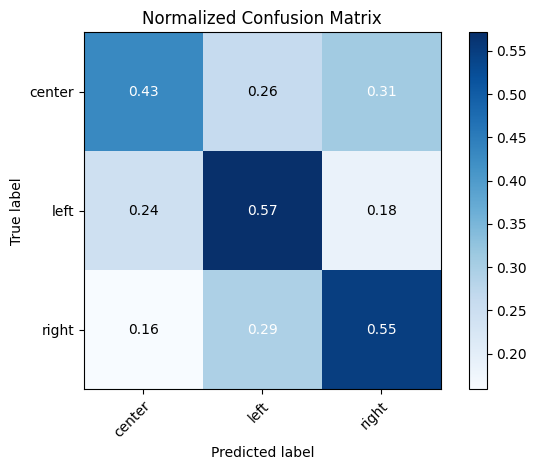

In [ ]:
from sklearn.svm import LinearSVC

clf_base_base = Pipeline([
    ('features', TfidfVectorizer(stop_words='english')),
    ('classifier', LinearSVC())
])

clf_base_base.fit(X_train, y_train)
evaluate_clf(clf_base_base, X_test, y_test, classes=le.classes_)

### Pure stylometry 1: StylometryFeatrues + RF/XGB

(375,) (375,)
              precision    recall  f1-score   support

           0       0.41      0.40      0.41       130
           1       0.46      0.44      0.45       120
           2       0.40      0.42      0.41       125

    accuracy                           0.42       375
   macro avg       0.42      0.42      0.42       375
weighted avg       0.42      0.42      0.42       375



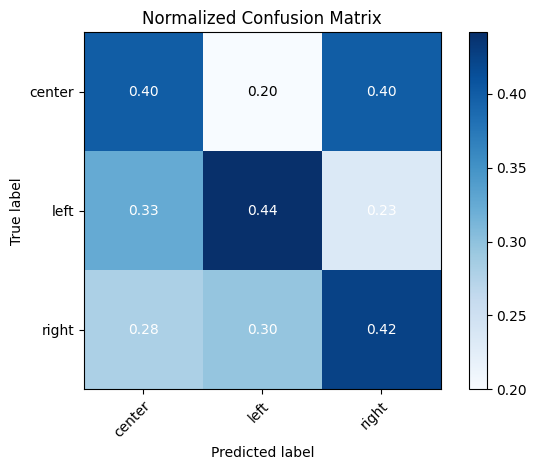

In [ ]:
data_type = 'style'
style_rf = rf_finetuning(data_type)
evaluate_clf(style_rf, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:48:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


(375,) (375,)
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       130
           1       0.41      0.54      0.47       119
           2       0.44      0.35      0.39       126

    accuracy                           0.42       375
   macro avg       0.42      0.42      0.42       375
weighted avg       0.42      0.42      0.42       375



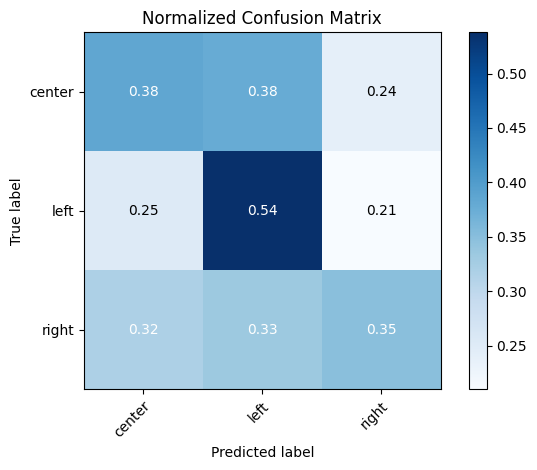

In [ ]:
data_type = 'style'
style_xgb = xgb_finetuning(data_type)
evaluate_clf(style_xgb, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)

### Pure stylometry 2.0: PosFeatrues + RF/XGB

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [21:53:08] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


(375,) (375,)
              precision    recall  f1-score   support

           0       0.41      0.42      0.41       130
           1       0.39      0.44      0.41       119
           2       0.35      0.30      0.32       126

    accuracy                           0.38       375
   macro avg       0.38      0.38      0.38       375
weighted avg       0.38      0.38      0.38       375



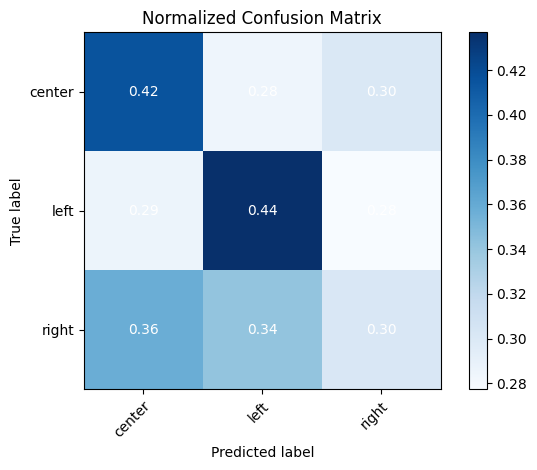

In [ ]:
data_type = 'pos'
style_rf = rf_finetuning(data_type)
evaluate_clf(style_rf, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)

In [ ]:
data_type = 'pos'
style_xgb = xgb_finetuning(data_type)

(375,) (375,)
              precision    recall  f1-score   support

           0       0.35      0.33      0.34       132
           1       0.31      0.30      0.30       125
           2       0.25      0.28      0.27       118

    accuracy                           0.30       375
   macro avg       0.30      0.30      0.30       375
weighted avg       0.30      0.30      0.30       375



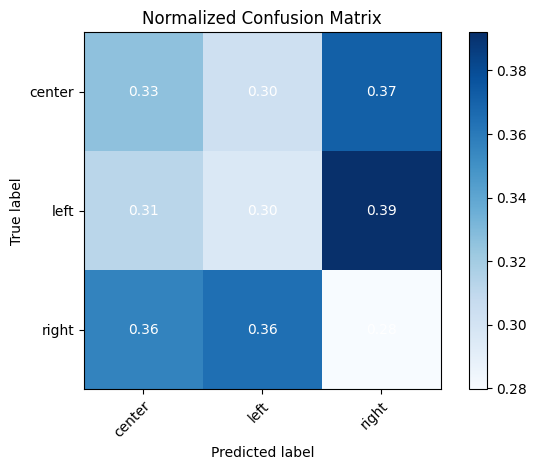

In [60]:
evaluate_clf(style_xgb, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)

### Stylometry with TFIDF 0: StylometryFeatrues + SVM

In [ ]:
from sklearn.svm import LinearSVC

data_type = 'style_tfidf'
clf_base = LinearSVC()
clf_base.fit(pipelines_data[data_type]['X_train'], pipelines_data[data_type]['y_train'])
evaluate_clf(clf_base, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)

### Stylometry with TFIDF 1:  StylometryFeatrues + RF/XGB

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [23:54:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


(375,) (375,)
              precision    recall  f1-score   support

           0       0.41      0.37      0.39       132
           1       0.38      0.51      0.44       103
           2       0.51      0.43      0.47       140

    accuracy                           0.43       375
   macro avg       0.43      0.44      0.43       375
weighted avg       0.44      0.43      0.43       375



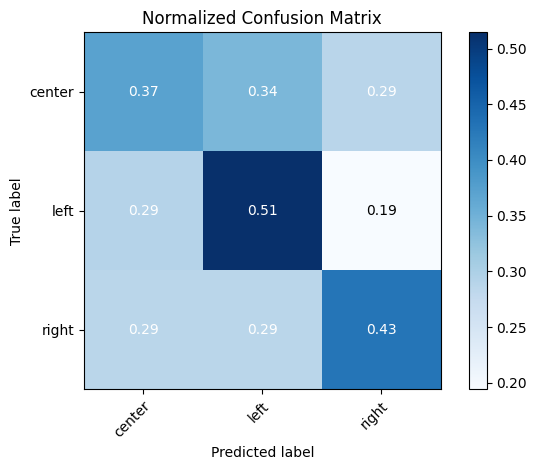

In [ ]:
data_type = 'style_tfidf'
style_rf = rf_finetuning(data_type)
evaluate_clf(style_rf, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)

In [ ]:
data_type = 'style_tfidf'
style_xgb = xgb_finetuning(data_type)

(375,) (375,)
              precision    recall  f1-score   support

           0       0.50      0.42      0.46       132
           1       0.53      0.54      0.53       125
           2       0.51      0.59      0.55       118

    accuracy                           0.51       375
   macro avg       0.51      0.52      0.51       375
weighted avg       0.51      0.51      0.51       375



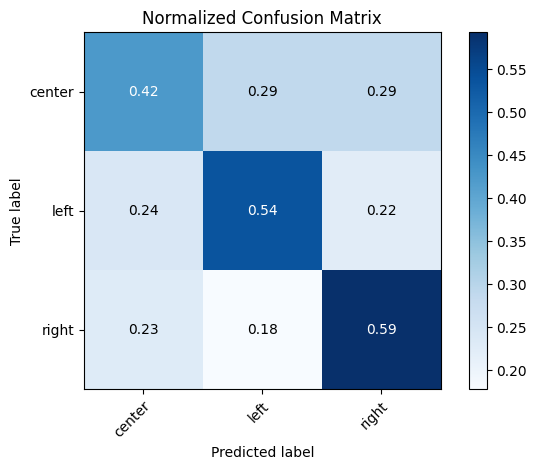

In [23]:
evaluate_clf(style_xgb, pipelines_data[data_type]['X_test'], y_test, classes=le.classes_)